# Twitter Streaming Application

**Andrea Soto | Exercise 2 | MIDS W205 - Storing and Retrieving Data**

---

## Project Overview

In this exercise I developed an application that reads a stream of tweets from the Twitter API, parses the tweets to count the number of occurrences of each word in the stream of tweets, and writes the final results to a Postgres database.

The architecture is shown in the image below.

> ADD IMAGE HERE

The directory structure of the project is shown below.

In [11]:
!tree -I 'streamparse_tweetwordcount*|_build*|_resources'

.
|-- Description of Serving Scripts.ipynb
|-- Develop Code.ipynb
|-- EX2Tweetwordcount
|   |-- config.json
|   |-- dev-resources
|   |-- fabfile.py
|   |-- logs
|   |-- project.clj
|   |-- src
|   |   |-- bolts
|   |   |   |-- __init__.py
|   |   |   |-- parse.py
|   |   |   `-- wordcount.py
|   |   `-- spouts
|   |       |-- __init__.py
|   |       `-- tweets.py
|   |-- tasks.py
|   |-- test
|   |-- topologies
|   |   `-- tweetwordcount.clj
|   `-- virtualenvs
|       `-- wordcount.txt
|-- Jupyter Notebook.ipynb
|-- README.md
|-- analysis
|   |-- finalresults.py
|   |-- histogram.py
|   |-- plot.png
|   `-- top20.py
`-- screenshots

11 directories, 19 files


In [1]:
%%html
<style>
table {float:left}
</style>

The main directories of the project are:

- **EX2Tweetwordcount:** Location of the storm project where the spouts, bolts, and topology scripts reside
- **analysis:** Location of the python servicing scripts that query the Postgres database
- **screenshots:** Location of the three screen-shots that show the end-to-end execution of the application

The description of the main files of the project and their location are shown in the tables below.

### Storm Application Files
|File Name|Location|Description|
|:--|:-|:--|
|tweetwordcount.clj  |./EX2Tweetwordcount/topologies/|Application topology|
|tweets.py|./EX2Tweetwordcount/src/spouts/|Spout to collect tweets|
|parse.py|./EX2Tweetwordcount/src/bolts/|Bolt to parse tweet and clean words|
|wordcount.py|./EX2Tweetwordcount/src/bolts/|Bolt to count words and update Postgres|

### Servicing Files (Query Postgres Database)
|File Name|Location|Description|
|:--|:--|:--|
|finalresults.py|./analysis/|Return the count of a word. If a word is not provided, it returns all word counts|
|histogram.py|./analysis/|Return all words with count between a given interval|
|top20.py|./analysis/|Return the top-20 words by count and create a bar-chart saved as 'plot.png'|

---
## Streaming Overview

The following commands were used to run the storm application and collect tweets:

> `cd EX2Tweetwordcount`  

> `sparse run`

Tweets were collected for approximately one day starting December 3 and ending December 4. The number of distinct words encountered and the total count of all words is shown below.

In [2]:
import psycopg2
import time
import sys

conn = psycopg2.connect(database="tcount", user="postgres")
cur = conn.cursor()

summary = []
sql = "select count(*) from Tweetwordcount ;" 
cur.execute(sql)
summary.append(('Number of distinct words:\t', cur.fetchall()[0][0]))

sql = "select sum(count) from Tweetwordcount ;" 
cur.execute(sql)
summary.append(('Total count of all words:\t', cur.fetchall()[0][0]))

conn.commit()
conn.close()

for i,j in summary:
    print i+"{:,}".format(j)

Number of distinct words:	61,569
Total count of all words:	3,702,525


---
# Servicing scripts

This section describes how to use the three servicing scripts. The following descriptions assumed the scripts are runned from the main project directory.

---
# finalresults.py

Given a word, return the total number of occurrences of the word in the stream. 

If a word is not provided, it returns all the word counts in alphabetical order. Since there are over 60,000 words, the outpt is limited to the first N word counts. The parameter N can be sent as an input, with the default being 25 words.

**USAGE**

To get the number of occurances of a single word:  
> `python analysis/finalresults.py hello`
    
Get all the word counts, sorted alphabetically, one per line:
> `python analysis/finalresults.py`
    
By default, only the first 25 words are printed to the console. The number of words shown can be increased by sending an integer as a parameter. The example below would show the first 500 words.
> `python analysis/finalresults.py 500`

## Sample Output of `finalresults.py`

The following examples show queries while the stream application was running and after the applicaiton was terminated. 

The queries done while the application was running were used to make sure the application was running properly and that the counts were increasing. It was interesting to see how the words in the results change over time.

### Query all words

In [158]:
# Query at the beginning of tweet collection
!python analysis/finalresults.py 10

First 10 word-counts (out of 777 words):

        Word  Count
           a  63
        able  2
       about  7
   according  1
     account  2
    actually  3
     address  3
       adele  1
      adidas  2
       after  1


In [16]:
# Query after some time had pass
!python analysis/finalresults.py 10

First 10 word-counts (out of 10059 words):

        Word  Count
           a  4168
      aaaaah  2
      aaaand  2
       aampa  2
       aampp  2
       aaood  2
       aaron  2
      aatuit  2
          ab  12
     abandon  2


In [34]:
# Query at the end of tweet collection
!python analysis/finalresults.py 10

First 10 word-counts (out of 61569 words):

        Word  Count
           `  1
           a  97611
          aa  31
         aaa  12
        aaaa  4
       aaaaa  2
      aaaaaa  5
  aaaaaaaaaa  2
 aaaaaaaaaaa  1
aaaaaaaaaaaaaaahhhhh  2


### Query word 'the' at different moments

In [9]:
!python analysis/finalresults.py the

Number of occurences of 'the':  4585 	@ Thu Dec  3 03:37:58 2015


In [105]:
!python analysis/finalresults.py the

Number of occurences of 'the':  60769 	@ Thu Dec  3 05:16:51 2015


In [1]:
!python analysis/finalresults.py the

Number of occurences of 'the':  150201 	@ Fri Dec  4 03:06:11 2015


In [5]:
# Final count of 'the'
!python analysis/finalresults.py the

Number of occurences of 'the':  150201 	@ Fri Dec  4 03:06:32 2015


---
# histogram.py

Given an interval defined by two integers k1 and k2, return all the words that have a count between the interval (including interval limits).

**USAGE**

To get all the words with a frequency between 1500 and 2000:  
> `python analysis/histogram.py 1500 2000`

By default, only the first 25 words are printed to the console. The number of words shown can be increased by sending a third integer as a parameter. The example below would show the first 50 words.
> `python analysis/histogram.py 1500 2000 50`

## Sample Output of histogram.py

In [22]:
# Query while stream application was running
!python analysis/histogram.py 1000 1100

Reporting 5 words (out of 5 words):

        Word  Count
         our  1040
         her  1047
      weeknd  1070
       would  1072
        back  1087


In [4]:
# Query after termination
!python analysis/histogram.py 1000 1100

Reporting 25 words (out of 32 words):

        Word  Count
relationship  1002
      chance  1005
       smile  1007
        fans  1008
          yo  1009
        asks  1010
         far  1020
     answers  1020
       media  1026
        full  1026
        gone  1031
        mama  1031
        must  1034
     prayers  1035
        past  1042
        turn  1042
         wow  1044
       hours  1045
    probably  1046
       story  1048
        fall  1049
      havent  1051
       least  1064
           s  1069
    violence  1082


In [5]:
# Increase words shown to 30
!python analysis/histogram.py 1000 1100 30

Reporting 30 words (out of 32 words):

        Word  Count
relationship  1002
      chance  1005
       smile  1007
        fans  1008
          yo  1009
        asks  1010
         far  1020
     answers  1020
       media  1026
        full  1026
        gone  1031
        mama  1031
        must  1034
     prayers  1035
        past  1042
        turn  1042
         wow  1044
       hours  1045
    probably  1046
       story  1048
        fall  1049
      havent  1051
       least  1064
           s  1069
    violence  1082
         top  1082
        goes  1083
          vs  1086
        rest  1087
        true  1092


---
# top20.py

This script finds the top-20 words by count.

It prints the words to the console and creates a bar-chart called `plot.png` in the directory where the script is called. If plot.png already exitst, the file will be overwritten.

In the example below, the script was run from the project directory. The file `plot.png` was then moved to the analysis folder.

**USAGE**

To get the top-20 words by count:  
> `python analysis/top20.py`

### Sample Output

In [9]:
!python analysis/top20.py
!mv plot.png analysis/

Top-20
ID     Word  Count
 1       the  150201
 2         i  122672
 3       you  99256
 4         a  97611
 5        to  88872
 6       and  51924
 7        in  48953
 8        of  47513
 9        is  44492
10       for  42390
11        my  34410
12      this  30196
13        on  29920
14        me  29550
15        it  28681
16        im  27679
17      that  27270
18        be  24402
19      when  23132
20        so  22948


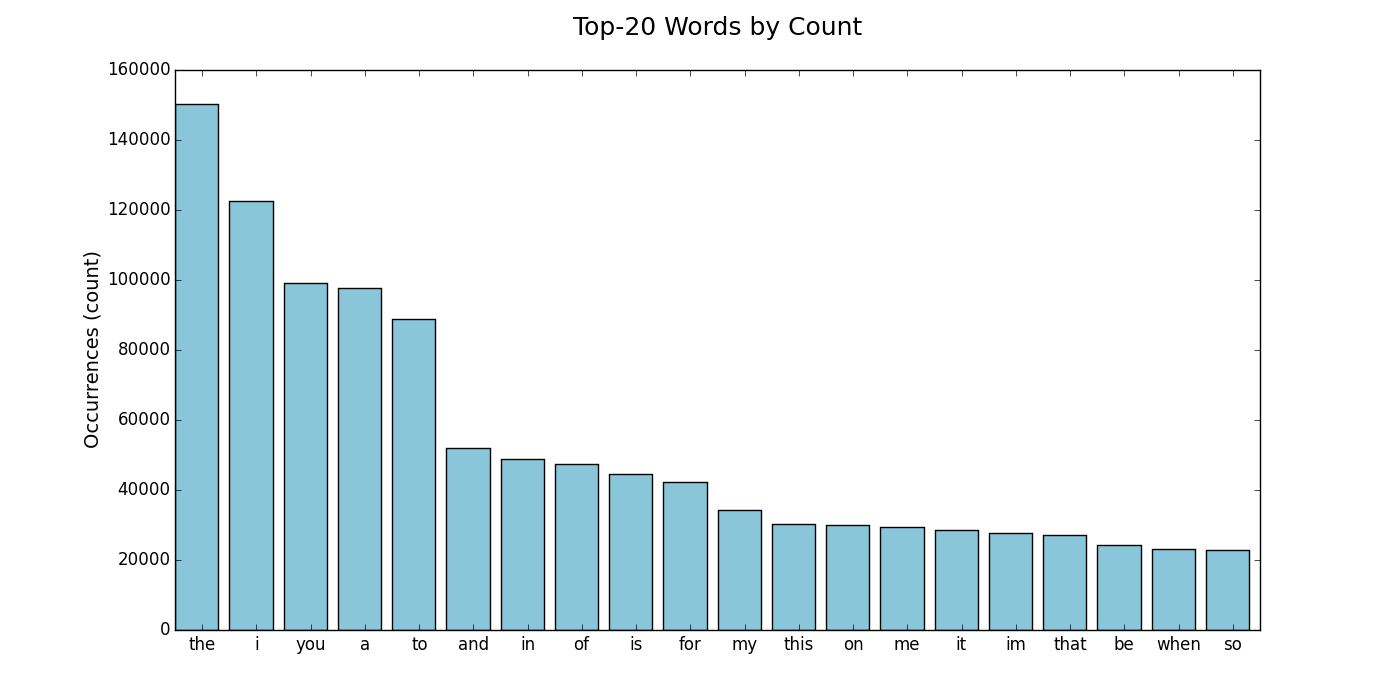

In [10]:
from IPython.display import Image
Image(filename='analysis/plot.png')

![Top20 Words](analysis/plot.png)